<h1> STAT 301 Project: Prediction of Data Science job salaries </h1> 

<strong> Data Description </strong>

Our dataset revolves around the aggregation of various Data Science job information from diverse countries. The job titles range include data scientists, analysts, engineers as well as ML engineers. There are total of 11 different variables, including employment type, salary, remote and etc. This allows the audience to gain valuable insights on the job market and how the salary varies depending on certain conditions / details of the jobs. The dataset is available in a CSV file and was web-scraped from an AI salary finder website, containing many jobs related to technology. The dataset contains 606 rows of jobs with more than 50% being from the US, just under 10% from UK and the rest are from various other countries. 

<strong> Columns: </strong>
- ```work_year``` (dbl):	The year the salary was paid.
- ```experience_level``` (chr):	The experience level in the job during the year with the following possible values: EN Entry-level / Junior MI Mid-level / Intermediate SE Senior-level / Expert EX Executive-level / Director
- ```employment_type``` (chr):	The type of employement for the role: PT Part-time FT Full-time CT Contract FL Freelance
- ```job_title``` (chr):	The role worked in during the year.
- ```salary``` (dbl):	The total gross salary amount paid.
- ```salary_currency``` (chr):	The currency of the salary paid as an ISO 4217 currency code.
- ```salary_in_usd``` (dbl):	The salary in USD (FX rate divided by avg. USD rate for the respective year via fxdata.foorilla.com).
- ```employee_residence``` (chr):	Employee's primary country of residence in during the work year as an ISO 3166 country code.
- ```remote_ratio``` (dbl):	The overall amount of work done remotely, possible values are as follows: 0 No remote work (less than 20%) 50 Partially remote 100 Fully remote (more than 80%)
- ```company_location``` (chr):	The country of the employer's main office or contracting branch as an ISO 3166 country code.
- ```company_size``` (chr):	The average number of people that worked for the company during the year: S less than 50 employees (small) M 50 to 250 employees (medium) L more than 250 employees (large)

<strong> Question: </strong> What is the average salary level for Data Science jobs and its underlying relationship for different job title, location and remote ratio?

As the data contains various statistics about the data science jobs, I am able to predict the salary based on different characteristics of the job. For this project, I will be answering a predictive question while taking confounders, optimal inputs and other assumptions into consideration for an accurate result (with accuracy being also measured via various metrics like R^2).

<h3> Exploratory Data Analysis & Visualization </h3>

**Reading Data & Importing Libraries**

In [2]:
library(tidyverse)
library(repr)
library(broom)
library(leaps)
library(moderndive)
library(dplyr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [3]:
#Reading Data
df_jobs_raw <- read_csv("./ds_salaries.csv")
head(df_jobs_raw)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


**Data Cleaning/Wrangling**

In [4]:
#Selecting necessary columns used for analysis
#Converting ratio into proper percentile form
df_jobs <- df_jobs_raw |> 
        mutate(remote_ratio = remote_ratio / 100) |>
        select(work_year, experience_level, employment_type, employee_residence, job_title, salary_in_usd, remote_ratio, company_location, company_size)

In [5]:
#Converting country codes into actual country names for better interpretation
unique(df_jobs$employee_residence)

country_dict <- c(
  DE = "Germany", JP = "Japan", GB = "United Kingdom", HN = "Honduras", US = "United States",
  HU = "Hungary", NZ = "New Zealand", FR = "France", IN = "India", PK = "Pakistan",
  PL = "Poland", PT = "Portugal", CN = "China", GR = "Greece", AE = "United Arab Emirates",
  NL = "Netherlands", MX = "Mexico", CA = "Canada", AT = "Austria", NG = "Nigeria",
  PH = "Philippines", ES = "Spain", DK = "Denmark", RU = "Russia", IT = "Italy",
  HR = "Croatia", BG = "Bulgaria", SG = "Singapore", BR = "Brazil", IQ = "Iraq",
  VN = "Vietnam", BE = "Belgium", UA = "Ukraine", MT = "Malta", CL = "Chile",
  RO = "Romania", IR = "Iran", CO = "Colombia", MD = "Moldova", KE = "Kenya",
  SI = "Slovenia", HK = "Hong Kong", TR = "Turkey", RS = "Serbia", PR = "Puerto Rico",
  LU = "Luxembourg", JE = "Jersey", CZ = "Czech Republic", AR = "Argentina", DZ = "Algeria",
  TN = "Tunisia", MY = "Malaysia", EE = "Estonia", AU = "Australia", BO = "Bolivia",
  IE = "Ireland", CH = "Switzerland"
)
# Assuming df_jobs is your data frame and employee_residence contains the country codes
df_jobs <- df_jobs_raw %>%
  mutate(employee_residence = country_dict[employee_residence])

[1] "DE" "JP" "GB" "HN" "US" "HU" "NZ" "FR" "IN" "PK" "PL" "PT" "CN" "GR" "AE"
[16] "NL" "MX" "CA" "AT" "NG" "PH" "ES" "DK" "RU" "IT" "HR" "BG" "SG" "BR" "IQ"
[31] "VN" "BE" "UA" "MT" "CL" "RO" "IR" "CO" "MD" "KE" "SI" "HK" "TR" "RS" "PR"
[46] "LU" "JE" "CZ" "AR" "DZ" "TN" "MY" "EE" "AU" "BO" "IE" "CH"

In [6]:
#Categorizing each job titles into big categories for data exploration

jobs <- c("Science Scientist", "Analytics Analyst", "Engineer Engineering ETL", "Architect", "Machine Learning / Computer Vision NLP")

# Apply function to categorize jobs into one of the above and create a new column
df_jobs$job_category <- apply(df_jobs, 1, function(row) {
    s1 <- unlist(strsplit(row["job_title"], " "))  # Unlist to get a vector of words

    # Check for overlaps
    for (j in jobs) {
        for (k in unlist(strsplit(j, " "))) {
            if (k %in% s1) {  # Check if the word is in the job title
                return(j)  # Return "hi" if a match is found
            }
        }
    }
    return("Other")  # Return "bye" if no match is found
})

# Display the updated data frame with the new job_category column
print(unique(df_jobs$job_category))

[1] "Science Scientist"                     
[2] "Engineer Engineering ETL"              
[3] "Analytics Analyst"                     
[4] "Machine Learning / Computer Vision NLP"
[5] "Other"                                 
[6] "Architect"                             


<h4> Visualization </h4>

**Figure 1**

Figure 1 is a boxplot depicting the salary levels and its average for the "Data Scientist" job positions. The levels are seperated by experience level and the company size to visualize the levels of varying groups in the data. For both mid and senior level data scientists, the small companies pay drastically less, while the entry level positions seems pay fairly.

This plot is relevant to the main question, as I want to infer and predict the salary levels of jobs in the data science market based on different groups in order to analyze the fairness of the pay and thriving jobs.
Hence, it is useful to look at the salary levels using a boxplot depending on various possible predictor variables to explore how the salary is distributed for different groups across the market.

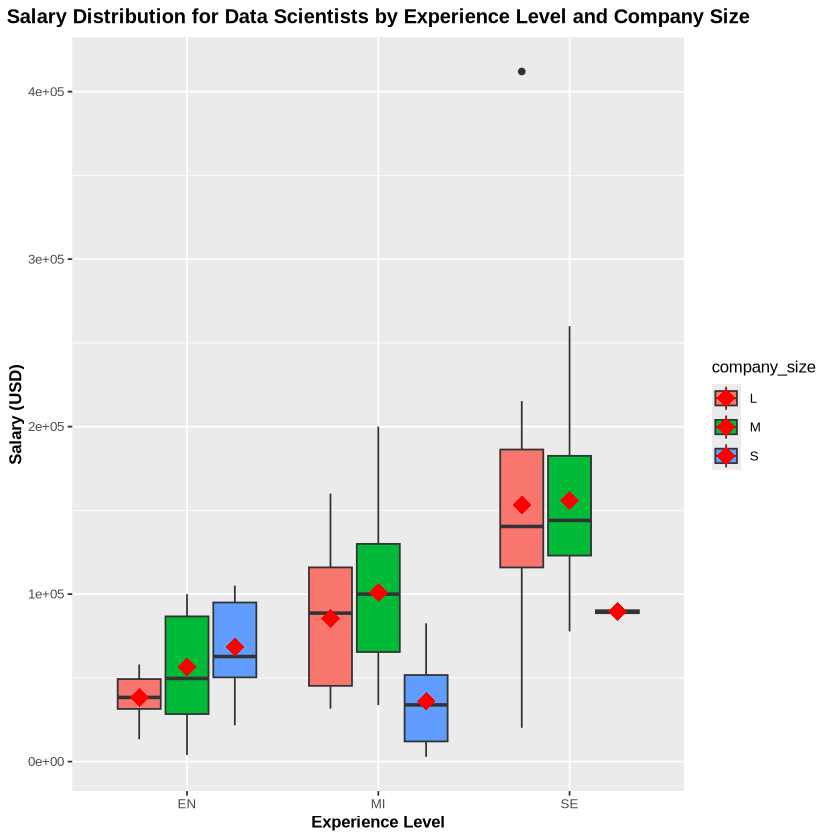

In [6]:
data_science_box_plot <- df_jobs |>
             filter(job_title == "Data Scientist") |>
             ggplot() +
             geom_boxplot(aes(x = experience_level, y = salary_in_usd, fill = company_size)) +
             ggtitle("Salary Distribution for Data Scientists by Experience Level and Company Size") +
             labs(x = "Experience Level", y = "Salary (USD)") +
             stat_summary(aes(x = experience_level, y = salary_in_usd, fill = company_size),
                          fun = mean, colour = "red", geom = "point", position = position_dodge(width = 0.75),
                          shape = 18, size = 5) +
              theme(
                  text = element_text(size = 10),
                  plot.title = element_text(face = "bold", hjust=0.5),
                  axis.title = element_text(face = "bold"))
data_science_box_plot

**Figure 2**

Below is a barplot, showing the aggregated counts of different job categories across the market. I sectioned the job titles to more general job categories (Analyst, Scientist, Machine Learning, etc.) and by experience level.
This plot is also relevant as I can look at how common / spread each jobs are across the job board, allowing me to take into consideration the imbalance or the abundance of certain jobs in the market during this project.

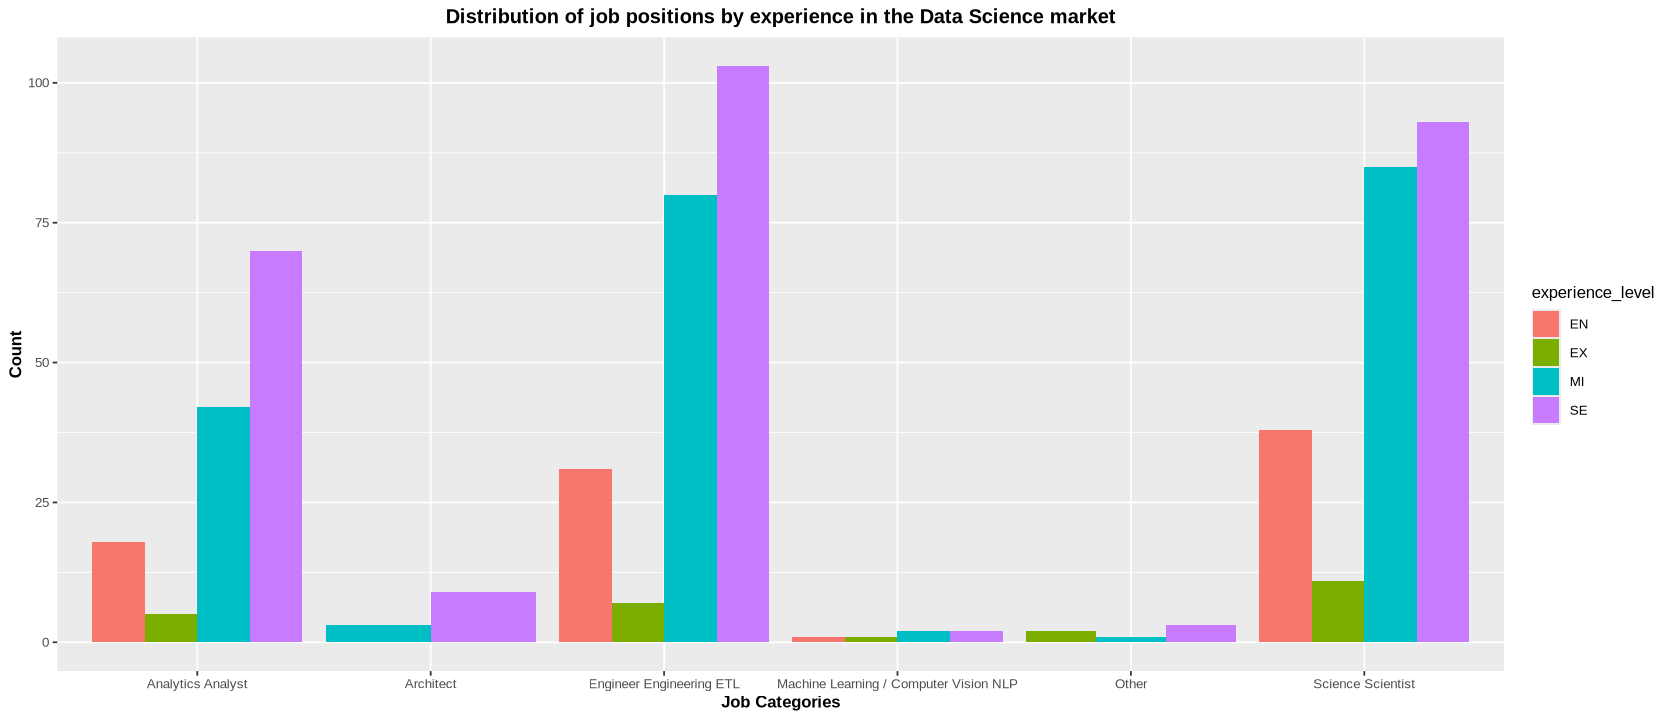

In [7]:
options(repr.plot.width = 14, repr.plot.height = 6) 

salary_barplot <- df_jobs |>
             ggplot(aes(x = job_category, fill=experience_level)) +
             geom_bar(position="dodge") +
             ggtitle("Distribution of job positions by experience in the Data Science market") +
             labs(x = "Job Categories", y = "Count") +
              theme(
                  text = element_text(size = 10),
                  plot.title = element_text(face = "bold", hjust=0.5),
                  axis.title = element_text(face = "bold"))
salary_barplot

## Methods and Plan & Computational Code and Output

**Methods & Plan**

*Model Chosen*: Additive Linear Regression Model (MLR).

$$ 
\text{Salary}_i = \beta_0  + \beta_1 \times \text{ExperenceLevel}_i + \beta_2 \times \text{CompanySize}_i + \beta_3 \times \text{Currency}_i  + \epsilon_i 
$$

- Why the model is appropriate:
  1. This model is appropriate for my question chosen, as I will be using covariates to predict a continuous variable (data science job salaries). I chose MLR instead of SLR in order to consider different dimensions that can possibly contribute to the salary (by fitting lines with different means for each covariate). I will also be able to prevent possible confounding by adding multiple covariates -- by considering different variables, the model will be able to detect significance of each variables independently.

  2. The linear regression model compared to other complex models is also much more interpretable due to its simplicity in fitting.

  3. By EDA, we saw that there were definite variances in salary levels given experience level and company size/prestige, which make it good covariates to fit regression on. The currency is included to deal with confounding issues. Currency levels can affect the numerical values of salary levels depending on company's origin.
  
- Assumptions:
  1. The data has a linear relationship with the Y (salary) -- each X that I use must have a decent linear relationship with Y.
  2. Independent errors for each level of covariates for every covariate with salary level.
  3. Equal variance for each level of covariates for every covariate with salary level.
  4. The errors have to be normally distributed for each level of covariates for every covariate with salary level.
- Limitations:
  1. To begin, the data may not even have a strong linear relationship, and so it might not perform as well compared to other complex models.
  2. Multicollinearity: Unless VIF is conducted, simply fitting this model can inflate the standard error compared to other models (RandomForest) that reduces variance.
  3. Confounders: While it is an additive model, the confounders may not be known. Since I can't include every single covariate that exists (due to complexity & overfitting), there could be hidden confounders leading to the effects -- leading to incorrect prediction and fitting.
  4. Lack of complexity: Because the model doesn't include interaction terms since most of the covariates are categorical, it lacks the complexity and may fail to capture the varying patterns using different slopes for each covariate. This may significantly affect the quality of the prediction.

**Implementation of a proposed model**

In [7]:
library(glmnet)
library(modelr)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8


Attaching package: ‘modelr’


The following object is masked from ‘package:broom’:

    bootstrap




In [8]:
colnames(df_jobs)

[1] "...1"               "work_year"          "experience_level"  
 [4] "employment_type"    "job_title"          "salary"            
 [7] "salary_currency"    "salary_in_usd"      "employee_residence"
[10] "remote_ratio"       "company_location"   "company_size"      
[13] "job_category"

In [9]:
colnames(df_jobs)[1] <- "ID"

In [10]:
#Split data

df_jobs_training <- df_jobs |>
                    slice_sample(prop = 0.75)
df_jobs_test <- df_jobs |>
                anti_join(df_jobs_training, by = "ID")

print(paste0("Training Size: ",nrow(df_jobs_training)))
print(paste0("Testing Size: ",nrow(df_jobs_test)))

[1] "Training Size: 455"
[1] "Testing Size: 152"


In [21]:
#Fit additive model
additive_model <- lm(salary ~ experience_level + company_size + salary_currency, data=df_jobs_training)
head(tidy(additive_model, conf.int = 0.95), 6)

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),240495.9,361776.56,0.6647637,5.065555e-01,-470560.61,951552.47
experience_levelEX,279415.8,94048.62,2.9709718,3.133867e-03,94567.22,464264.41
experience_levelMI,138541.4,55216.07,2.5090774,1.246894e-02,30016.54,247066.24
experience_levelSE,261027.3,54933.83,4.7516672,2.749212e-06,153057.15,368997.39
company_sizeM,-120495.9,39128.10,-3.0795240,2.205294e-03,-197400.56,-43591.30
company_sizeS,-125317.9,57004.44,-2.1983885,2.844986e-02,-237357.73,-13278.09


In [14]:
#Find RSS, RSE and statistics in glance() function to evaluate model on new data
model_stats <- df_jobs_training |>
    mutate(residual = residuals(additive_model)) %>%
    summarize(RSS = sum(residual^2),
             mse = (1/nrow(df_jobs_training))*sqrt(sum(residual^2))) 
    
model_results <- glance(additive_model) |>
                bind_cols(model_stats)
model_results

r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs,RSS,mse
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>
0.9597421,0.9577896,359654.4,491.5544,1.029622e-286,21,-6455.111,12956.22,13050.99,5.60091e+13,433,455,5.60091e+13,16448.18


**Interpretation & Results:**


> From the results above, we first see both the R^2 and adjusted R^2 being ~0.959, as well as low p-value (via F-test), indicating that lots of the patterns/variances of the data is captured by the model (i.e. approximately 96% of the variance of the data is explained using this model) and it is statistically significant than null model. This was expected as the additive model is able to fit lines with different average salaries for different covariate groups, which helped predict salary levels for various attributes of the jobs. (2)

> However, we see some problems like inflated MSE of 16448.18 and high RSE (sigma) of 359654.4, as well as very high RSS, which show that there are still a lot of unexplainable error & inaccuracy by the model compared to the data. (1)

> These should be addressed by checking if the model violates LINE assumptions and performing back/forward selection to find possibly better covariates that can reduce uncertainty, along with ridge regression in order to deal with possible multi-collinearity issues between the covariates through shrinkage of parameters that give off high SE. (1)